In [430]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# jax
import jax.numpy as jnp
import time

import sys
import os
import importlib

# append path
path_ = os.path.abspath(os.path.join('..', '00_utils'))
if path_ not in sys.path:
    sys.path.append(path_)
    
path_ = os.path.abspath(os.path.join('..', '00_models'))
if path_ not in sys.path:
    sys.path.append(path_)
    
path_ = os.path.abspath(os.path.join('..', '00_utils_training'))
if path_ not in sys.path:
    sys.path.append(path_)

from data_generation import generate_ode_data
from non_parametric_collocation import collocate_data
from collocation_obj import Collocation

def reload_module(module_name, class_name):
    module = importlib.import_module(module_name)
    importlib.reload(module)
    return getattr(module, class_name)

In [434]:
PyomoModel = reload_module('nn_pyomo_base', 'NeuralODEPyomo')

class DataPreprocessor:
    def __init__(self, data_param):
        self.model_type = 'pyomo'
        self.N = data_param['N']
        self.noise_level = data_param['noise_level']
        self.ode_type = data_param['ode_type']
        self.data_param = data_param['extra_param']
        self.spacing_type = data_param['spacing_type']
        self.start_time = data_param['start_time']
        self.end_time = data_param['end_time']
        self.init_state = data_param['initial_state']
        self.test_size = getattr(data_param, 'test_size', None)
        
    def load_data(self):
        if self.model_type == 'pyomo':
            self.generate_nodes()
        else:
            self.nodes = jnp.linspace(self.start_time, self.end_time, self.N)
        
        # training    
        self.t, self.y, self.y_noisy, true_derivative = generate_ode_data(
            self.N, self.noise_level, self.ode_type, self.data_param, 
            min(self.nodes), max(self.nodes), 
            initial_state = self.init_state, t = self.nodes)
        
        self.true_derivative = true_derivative
        
        if self.test_size is not None:
            test_end_time = self.end_time + self.test_size
        else:
            test_end_time = max(self.nodes) + (max(self.nodes) - min(self.nodes))
        
        # testing
        self.init_state_test = self.y[-1]
        t_test, y_test, _, _ = generate_ode_data(
            self.N*2, self.noise_level, self.ode_type, self.data_param, 
            max(self.nodes), test_end_time, 
            spacing_type = "uniform", 
            initial_state = self.init_state_test)
        
        self.t_test = t_test
        self.y_test = y_test

    def generate_nodes(self):
        collocation = Collocation(self.N, self.start_time, self.end_time, self.spacing_type)
        self.nodes = collocation.compute_nodes()
        self.collocation = collocation
       
    def prepare_collocation(self):
        self.D = np.array(self.collocation.compute_derivative_matrix())
        
    def estimate_derivative(self):
        est_der, est_sol = collocate_data(self.y_noisy, self.t, 'EpanechnikovKernel', bandwidth=0.5)
        self.est_sol = np.array(est_sol)

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


In [556]:
data_params_vdp = {
    'N': 200, 'noise_level': 0.1,
    'ode_type': "van_der_pol",
    'extra_param': {"mu": 1, "omega": 1},
    'spacing_type': 'chebyshev',
    'initial_state': np.array([0.0, 1.0]),
    'detailed' : False
}

time_intervals = [(0, 15), (15, 30)]

t_list, y_true_list, y_noisy_list = [], [], []
D_list = []
est_sol_list = []

# --------------------------------------------- GENERATE DATA FOR EACH INTERVAL --------------------------------------------- #
for idx, (start_time, end_time) in enumerate(time_intervals):
    # update initial state for subsequent intervals
    if idx > 0:
        data_params_vdp['initial_state'] = y_true_list[-1][-1] 
    
    data_params_vdp['start_time'] = start_time
    data_params_vdp['end_time'] = end_time
    
    data_prep = DataPreprocessor(data_params_vdp)
    data_prep.load_data()
    data_prep.prepare_collocation()
    data_prep.estimate_derivative()
    
    # training
    y_noisy_list.append(data_prep.y_noisy)
    t_list.append(data_prep.t)
    D_list.append(data_prep.D)
    y_true_list.append(data_prep.y)
    est_sol_list.append(data_prep.est_sol)
    
    
    
# --------------------------------------------- MERGE DATA FROM ALL INTERVALS --------------------------------------------- #
ts = np.concatenate(t_list)         # Combined time vector
ys = np.vstack(y_noisy_list)        # Combined noisy observations
y_est = np.hstack(est_sol_list)     # Combined estimated solutions
Ds = D_list                         # List of derivative matrices for each interval

ys = np.array(ys)
ts = np.array(ts)
y_est = np.array(y_est).T

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")
/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


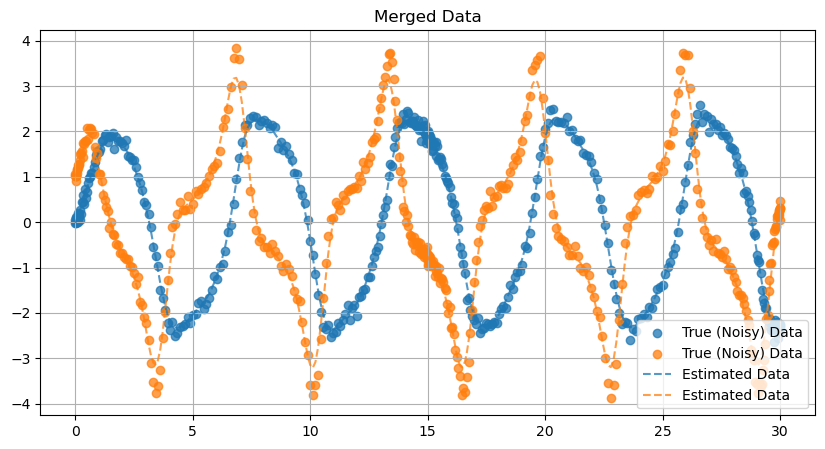

In [564]:
plt.figure(figsize=(10, 5))
plt.scatter(ts, ys[:, 0], label='True (Noisy) Data', alpha = 0.75)
plt.scatter(ts, ys[:, 1], label='True (Noisy) Data', alpha = 0.75)

plt.plot(ts, y_est, label='Estimated Data', ls = '--', alpha = 0.75)
plt.legend(loc ="lower right")
plt.grid(True)
plt.title("Merged Data")
plt.show()

In [558]:
import nn_pyomo_admm
importlib.reload(nn_pyomo_admm)
NeuralODEPyomoADMM = nn_pyomo_admm.NeuralODEPyomoADMM

tol = 1e-8
params = {"tol":tol, 
        #"dual_inf_tol": tol, "compl_inf_tol": tol, "constr_viol_tol": tol, 
        "halt_on_ampl_error" : 'yes', 
        "print_level": 5, "max_iter": 3000}

layer_sizes = [2, 32, 2]

ode_model = NeuralODEPyomoADMM(y_observed = ys, 
                        t = ts, # t
                        first_derivative_matrix = Ds, # derivative matrix
                        extra_input = None, # extra inputs
                        y_init = y_est,
                        layer_sizes = layer_sizes, act_func = "tanh", 
                        penalty_lambda_reg = 0.001, 
                        rho = 1.0,
                        time_invariant = True,
                        w_init_method = 'xavier', 
                        params = params
                        )

result = ode_model.admm_solve(iterations=10, tol_primal=1e-2, record = True)

----------------------------------------------------------------------------------------------------
ADMM Iteration 1/10; 0
----------------------------------------------------------------------------------------------------
Ipopt 3.14.16: tol=1e-08
halt_on_ampl_error=yes
print_level=5
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   131340
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    64729

Total number of variables.....................

In [559]:
result

{'primal_residual': [39.882793062535484,
  39.882793062525366,
  3.48091484400443,
  2.176704849895512,
  1.6611766604797304,
  1.3661963494746725,
  1.1677041521323435,
  1.051344967746431,
  0.9824963805441562,
  0.9393967583855576],
 'mse_diffrax': [106.73243619645046,
  114.16903319035471,
  5.082556076452793,
  1.300000938282798,
  0.3659975289416758,
  0.26394404818660466,
  0.29791111439800505,
  0.2534344378727594,
  0.20248121466204277,
  0.33271424889280893],
 'iter': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'time_elapsed': [24.5996150970459,
  25.558669328689575,
  32.29896068572998,
  33.251771688461304,
  34.26675462722778,
  35.22126579284668,
  36.164987564086914,
  37.08576226234436,
  37.978334188461304,
  38.90048837661743]}

In [560]:
case = 1
if case == 0:
    init_state = data_params_vdp['initial_state'] 
elif case == 1:
    init_state = jnp.array([0,1])
    
pred = ode_model.node_diffrax_pred(init_state, jnp.array(ts), None, 'consensus')

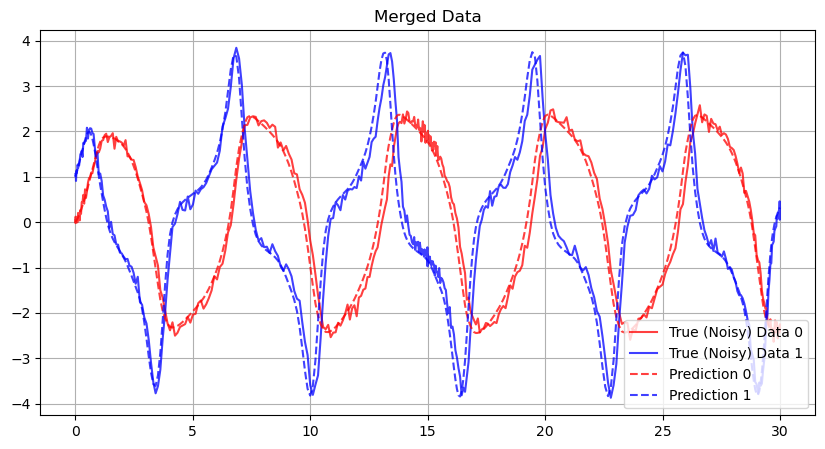

In [561]:
plt.figure(figsize=(10, 5))
plt.plot(ts, ys[:, 0], label='True (Noisy) Data 0', color = 'red', alpha = 0.75)
plt.plot(ts, ys[:, 1], label='True (Noisy) Data 1', color = 'blue', alpha = 0.75)

plt.plot(ts[:], pred[:,0], label='Prediction 0', color = 'red', ls = '--', alpha = 0.75)
plt.plot(ts[:], pred[:,1], label='Prediction 1', color = 'blue', ls = '--', alpha = 0.75)
plt.legend(loc ="lower right")
plt.grid(True)
plt.title("Merged Data")
plt.show()

---
---
### Check if the input data is correct by fitting a single model on half of the data

In [588]:
data_params_vdp_full = {
    'N': 300, 'noise_level': 0.2, 'test_size': 150,
    'ode_type': "van_der_pol",
    'extra_param': {"mu": 1, "omega": 1},
    'start_time': 0, 'end_time': 30,
    'spacing_type': 'chebyshev',
    'initial_state': np.array([0.0, 1.0]),
    'detailed' : False
}

data_prep = DataPreprocessor(data_params_vdp_full)
data_prep.load_data()
data_prep.prepare_collocation()
data_prep.estimate_derivative()

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


In [589]:
ys_single = np.array(data_prep.y_noisy)
ts_single = np.array(data_prep.t)
Ds_single = np.array(data_prep.D)
y_est_single = np.array(data_prep.est_sol)

In [590]:
class TrainerToyLocal:
    def __init__(self, y_noisy, t, D, layer_widths, act_func = 'tanh', y_init = None, penalty_lambda_reg = 0.001, time_invar = True, w_init_method = 'xavier', reg_norm = False, skip_collocation = np.inf):       
            
            self.y_noisy = y_noisy
            self.t = t
            self.D = D
            self.layer_widths = layer_widths
            self.act_func = act_func
            self.est_sol = y_init
            self.lambda_reg = penalty_lambda_reg
            self.time_invar = time_invar
            self.w_init_method = w_init_method
            self.reg_norm = reg_norm
            self.skip_collocation = skip_collocation
            
            self.pre_initialize = True
            self.time_elapsed = None
            self.termination = None
        
    def train_pyomo(self, params_model = None):
        
        self.model = PyomoModel(
                        self.y_noisy, # remember to pass noisy data
                        self.t, 
                        self.D,
                        self.layer_widths, 
                        act_func = self.act_func, 
                        y_init = self.est_sol, 
                        penalty_lambda_reg = self.lambda_reg, 
                        time_invariant = self.time_invar,
                        w_init_method = self.w_init_method, 
                        params = params_model,
                        reg_norm = self.reg_norm,
                        skip_collocation = self.skip_collocation
                        )
        
        self.model.build_model()
        result = self.model.solve_model()        
        self.time_elapsed = result['solver_time']
        self.termination = result['termination_condition']
        print(result)

tol = 1e-8
params = {"tol" : tol, "halt_on_ampl_error" : 'yes', "print_level": 5, "max_iter": 3000}
        
trainer = TrainerToyLocal(ys_single, ts_single, Ds_single, [2, 32, 2], act_func = 'tanh', y_init = y_est_single, penalty_lambda_reg = 0.001)
trainer.train_pyomo(params)

current_16_08


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:86: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-08
halt_on_ampl_error=yes
print_level=5
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   257142
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    97029

Total number of variables............................:      762
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      762
                     variables with only upper bounds:        0
Total number of

In [591]:
ys_single[0]
predictions = trainer.model.neural_ode(ys_single[0], ts_single)
predictions.shape

(300, 2)

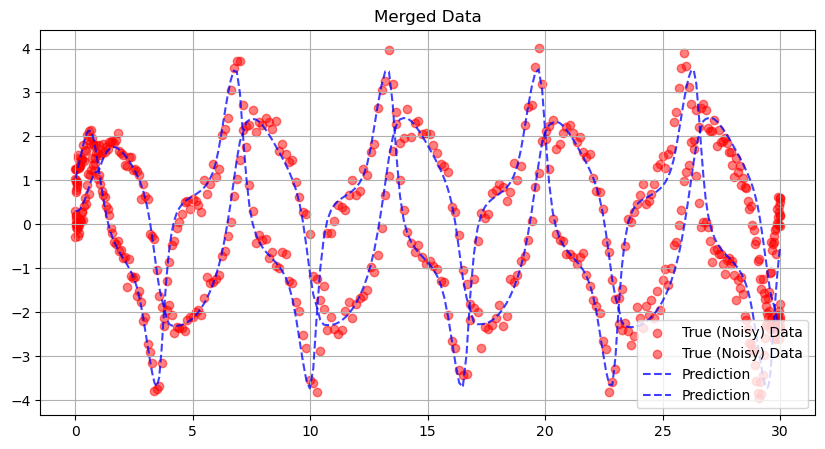

In [592]:
plt.figure(figsize=(10, 5))
plt.scatter(ts_single, ys_single[:,0], label='True (Noisy) Data', color = 'red', alpha = 0.5)
plt.scatter(ts_single, ys_single[:,1], label='True (Noisy) Data', color = 'red', alpha = 0.5)
plt.plot(ts_single[:], predictions, label='Prediction', color = 'blue', ls = '--', alpha = 0.75)
plt.legend(loc ="lower right")
plt.grid(True)
plt.title("Merged Data")
plt.show()